<a href="https://colab.research.google.com/github/ramonVDAKKER/teaching-quantitative-finance/blob/main/notebooks/simulation_of_sde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook simulation of stochastic processes

This notebook accompanies the course **Quantitative Finance** (BSc Econometrics and OR, Tilburg University) and considers the simulation of stochastic processes. The following processes will be considered:


*   Brownian motion;
*   Brownian motion with drift;
*   Geometric Brownian motion (GBM);
*   Ito diffusion processes $dX_t=a(t, X_t)dt + b(t, X_t) dW_t$, where $W$ is a standard Brownian motion and $X_0=x_0$.



## 0. Imports

In [1]:
import numpy as np
import pandas as pd
from ipywidgets import interact
import matplotlib.pyplot as plt

## 1. Brownian motion, Brownian motion with drift, and Geometric Brownian motion

The following cell introduces classes to simulate a Brownian motion, a Brownian motion with drift, and a Geometric Brownian motion.

In [2]:
class StochasticProcess:
    """Base class for simulating stochastic processes.

    Warning: This class should not be used directly. Use derived classes instead.
    """

    def __init__(self, name, time_grid, paths):
        self.name = name
        self.time_grid = time_grid
        self.paths = paths
        self.params = None

    def plot(self, num_paths=5):
        """Plots (minimum of number of available sample paths and num_paths) sample paths.

        Args:
            num_paths (int): number of sample paths to be plotted. Defaults to 5.
        """

        num_paths = min(self.paths.shape[0], num_paths)
        paths = self.paths[:num_paths, :].T
        title = f"{num_paths} simulated sample paths from {self.name}"
        if self.params is not None:
            title += f" with parameters: {[(k, v) for k, v in self.params.items()]}"
        pd.DataFrame(
            paths,
            columns=[f"path {j}" for j in range(1, 1 + num_paths)],
            index=self.time_grid,
        ).plot(kind="line", title=title, figsize=(25, 7))

    def avg_and_var_over_simulations(self):
        """Calculates, for each point on time-grid, the mean and variance over sample paths."""

        if not self.paths.shape[0] > 0:
            raise ValueError("Requires minimum of two paths.")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7))
        aux = np.mean(self.paths, axis=0)
        avg_df = pd.DataFrame(aux, columns=["Average over paths"], index=self.time_grid)
        avg_df.plot(kind="line", title="Average over sample paths", ax=ax1)
        aux = np.var(self.paths, axis=0)
        var_df = pd.DataFrame(
            aux, columns=["Var over sample paths"], index=self.time_grid
        )
        var_df.plot(kind="line", title="Var over sample paths", ax=ax2)
        return avg_df, var_df


class BrownianMotionWithDrift(StochasticProcess):
    """Class to simulate paths of a Brownian motion with drift, i.e. X_t = ct + W_t"""

    def __init__(self, drift, sigma, n, T, time_step, seed=None):

        if T < time_step:
            raise ValueError("Maturity T should be larger than time step.")
        if sigma < 0:
            raise ValueError("sigma should be strictly positive.")
        self.n = n
        self.T = T
        self.time_grid, self.time_step = np.linspace(
            0, self.T, num=1 + int(T / time_step), endpoint=True, retstep=True
        )  # note that time_step is adapted (if needed) in order to get equally-spaced grid
        if seed is not None:
            np.random.seed(seed)
        aux = np.random.normal(loc=0.0, scale=1.0, size=(self.n, len(self.time_grid)))
        self.paths = (
            np.cumsum(sigma * np.sqrt(time_step) * aux, axis=1) + drift * self.time_grid
        )
        super().__init__("Brownian Motion with drift", self.time_grid, self.paths)
        self.params = {"drift c": drift, "sigma": sigma}


class BrownianMotion(BrownianMotionWithDrift):
    """Class to simulate paths of a Brownian motion"""

    def __init__(self, sigma, n, T, time_step, seed=None):

        super().__init__(0, sigma, n, T, time_step, seed)
        self.name = "Brownian Motion"
        self.params = {"sigma": sigma}


class GeometricBrownianMotion(BrownianMotionWithDrift):
    """Class to simulate paths of a Geometric Brownian motion, i.e. X_t=X_0\exp((mu-0.5sigma^2)t+sigma*W_t)"""

    def __init__(self, starting_value, mu, sigma, n, T, time_step, seed=None):

        super().__init__(mu - 0.5 * sigma ** 2, sigma, n, T, time_step, seed)
        self.paths = starting_value * np.exp(self.paths)
        self.name = "Geometric Brownian Motion"
        self.params = {"starting_value": starting_value, "mu": mu, "sigma": sigma}


## 1.1 Brownian motion

The following cell simulates and plots 10 sample paths of a standard Brownian motion on the time-interval $[0, 5]$ where we use a time-step equal to $0.001$. Run the cell a few time to get a feeling for the variety of the sample paths.

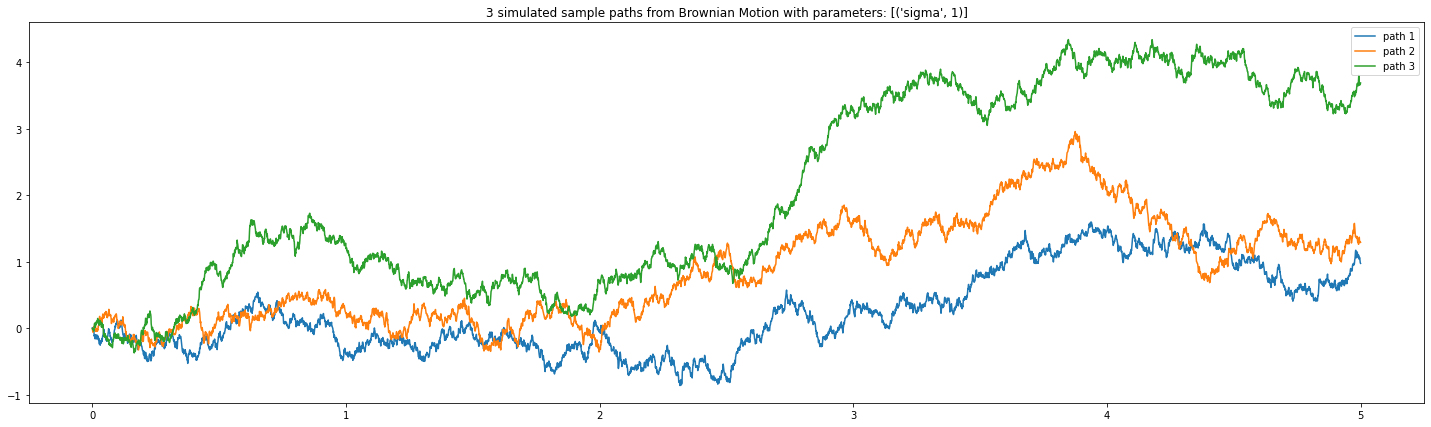

In [3]:
bm = BrownianMotion(sigma=1, n=10, T=5, time_step=0.001, seed=None)
bm.plot(3)

In case we want to be able to reproduce the simulated paths, we should fix the seed. See the following cell.

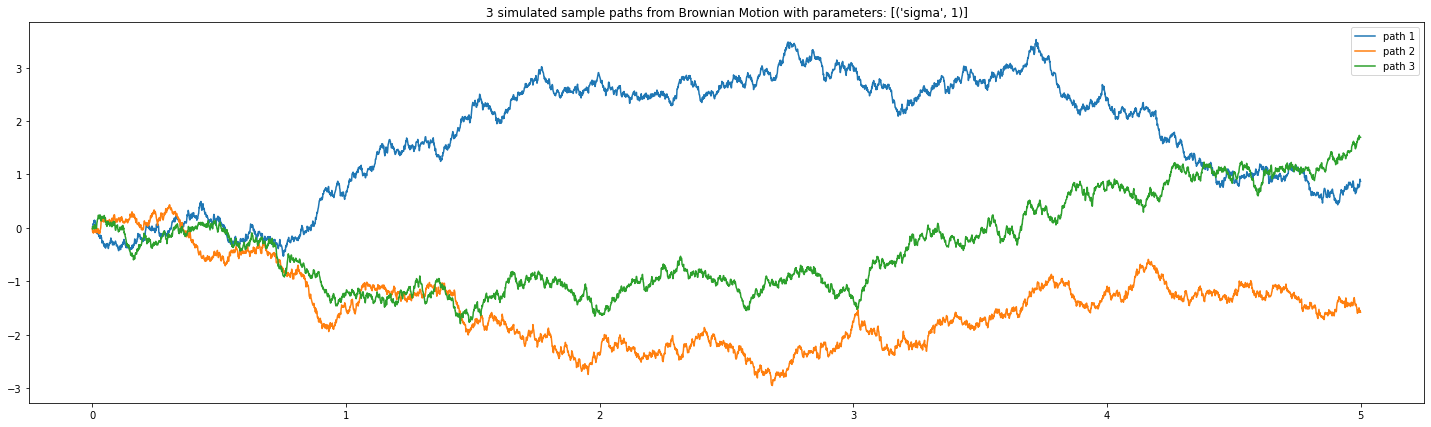

In [4]:
bm = BrownianMotion(sigma=1, n=10, T=5, time_step=0.001, seed=42)
bm.plot(3)

We have $\mathbb{E}W_t=0$ and $\operatorname{var}(W_t) = \sigma^2 t$. As a check on our code, we can try to verify these properties. Indeed, if we use a large number of sample paths $n$, then the law of large numbers implies that the sample mean of $W_t^{(i)}$, $i=1,\dots,n$, i.e. the simulated values of the process at time $t$, provides an approximation to $\mathbb{E}W_t=0$. Similarly, the sample variance of $W_t^{(i)}$, $i=1,\dots,n$, provides an approximation to  $\operatorname{var}(W_t)$. 

In the next cell we use $n=5000$ and compute the sample mean and sample variances of  $W_t^{(i)}$, $i=1,\dots,n$, for all $t$ on the time-grid. Please note that, as a next step, we could develop a statistical test.]

,Average over paths
5.0,-0.024902


,Var over sample paths
5.0,42.909561


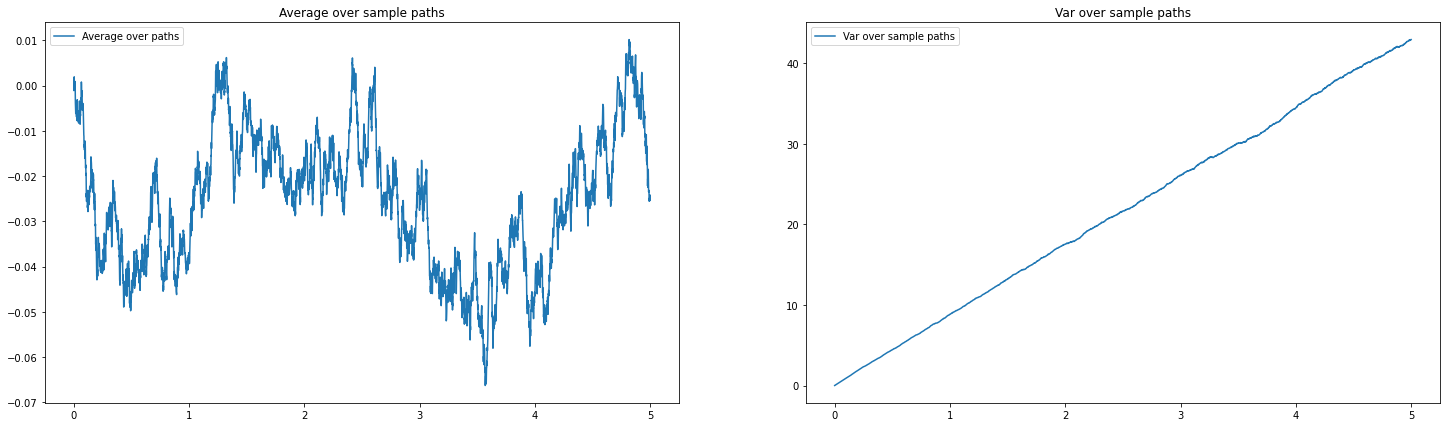

In [5]:
bm = BrownianMotion(sigma=3, n=5000, T=5, time_step=0.001, seed=None)
avg_df, var_df = bm.avg_and_var_over_simulations()
display(avg_df.tail(1))
display(var_df.tail(1))

## 1.2 Brownian motion with drift

In this section we consider a Brownian motion with drift, i.e. $X_t = ct + W_t$, where $W$ is a Brownian motion with variance $\sigma^2$ per unit-of-time.

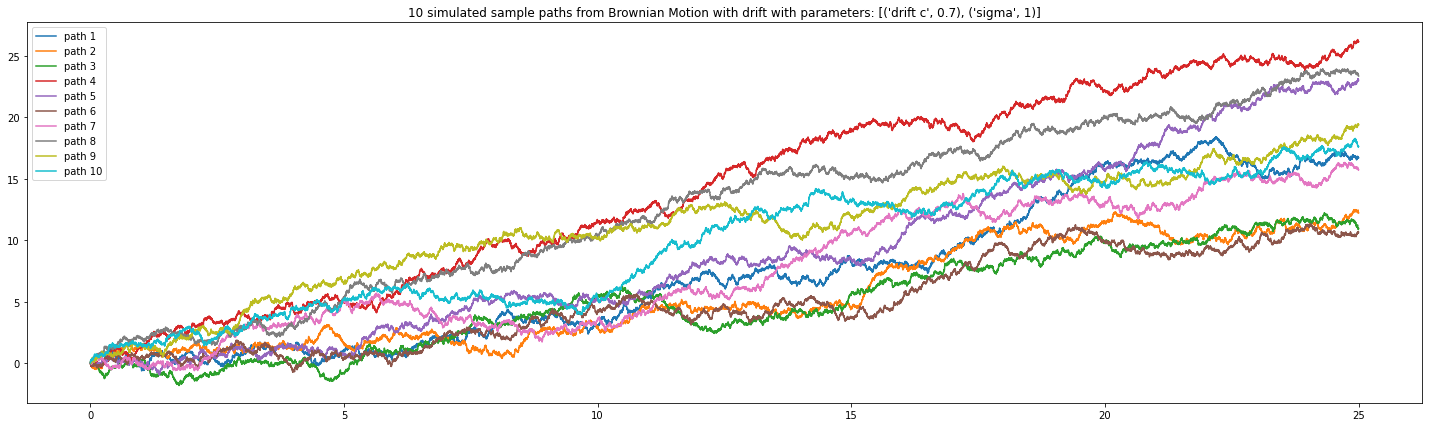

In [6]:
bmwd = BrownianMotionWithDrift(drift=0.7, sigma=1, n=10, T=25, time_step=0.001, seed=None)
bmwd.plot(10)

## 1.3 Geometric Brownian motion

In this section we discuss the Geometric Brownian motion. Recall that this process is described by the SDE $dX_t = \mu X_t dt + \sigma X_t dW_t$, where $X_0=x_0$ and $W$ is a standard Brownian motion. We have seen that this SDE has as solution $$X_t = X_0 \exp\left( (\mu - 0.5\sigma^2) t+ \sigma W_t\right).\qquad(\star)$$ So given a simulated path of $W$ we can obtain the simulated path of $X$. 

Note: in the next section we will discuss the Euler-method. This is a numerical approximation technique which we could have used to simulate, using the SDE, an approximation to $X_t$ in case we would not have been able to derive the closed-form solution $(\star)$.

In [7]:
@interact(mu=(0, 0.2), sigma=(0.01, 0.8))
def aux_plot_gbm(mu, sigma):
    gbm = GeometricBrownianMotion(starting_value=100, mu=mu, sigma=sigma, n=5, T=1, time_step=0.001, seed=None)
    gbm.plot(5)

interactive(children=(FloatSlider(value=0.1, description='mu', max=0.2), FloatSlider(value=0.405, description=…

## 3. Simulating Ito Diffusion processes using the Euler method

In this section we consider the simulation of processes that are described by SDEs of the form $$d X_t = a(t,X_t) dt + b(t, X_t) dW_t,$$ with $X_0=x_0$, $W$ a standard Brownian motion and where $a$ and $b$ are deterministic functions.

In special cases it is possible to obtain a closed-form solution which means that we can express $X_t$ in terms of $W_s$, $s\leq t$ and $t$. As an example, let us consider the GBM $dX_t = \mu X_t dt + \sigma X_t dW_t$, $X_0=x_0$. The solution is given by $X_t = X_0 \exp\left( (\mu - 0.5\sigma^2) t+ \sigma W_t\right)$. So given a simulated path of $W$ we can obtain the simulated path of $X$.

But how to proceed if we are not able to obtain a closed-form solution to the SDE? In that case we can resort to numerical approximations. Here we will discuss the Euler-method (also known as the Euler–Maruyama method).

To motivate this method let us recall that the above SDE means that, for $t,h\geq 0$, 
\begin{equation}
X_{t+h} - X_t  = \int_t^{t+h} a(u, X_u) du + \int_t^{t+h} b(u, X_u) dW_u.
\end{equation}
Now insert the approximations, for $u\in [t,t+h]$, $a(u,X_u) \approx a(t, X_t)$ and 
$b(u,X_u)\approx b(t, X_t)$. This yields
\begin{equation}
X_{t+h} - X_t  \approx a(t, X_t) h + b(t, X_t) (W_{t+h} -W_t).
\end{equation}
This motivates the Euler-method. Simulate an approximation to $X$ via the following recursive scheme. Choose a (small) time-step $h>0$, set $X_0=x_0$, and simulate $X_{(k+1)h}$, for $k\geq 0$, by
$$X_{(k+1)h} = X_{kh} + a(kh, X_{kh}) h +  b(kh, X_{kh}) \times \epsilon_k,$$
where $\epsilon_k$, $k\in\mathbb{N}$, are i.i.d. draws from the $N(0,h)$ distribution.

Warning: if we use the Euler-method for a given SDE, then we do not try or did not succeed to obtain a closed-form solution. However, one should still try to check (using the available sufficient conditions on the functions $a$ and $b$) if a solution to the SDE exists!

In [8]:
class ItoDiffusionEuler(BrownianMotion):
    """Class to simulate approximations to solution of SDE dX_t = a(t, X_t) dt + b(t, X_t) dW_t,
    X_0=x_0 and where W is a standard Brownian motion."""
        
    def __init__(
        self,
        starting_value,
        drift_function,
        volatility_function,
        n,
        T,
        time_step,
        seed=None,
    ):

        super().__init__(1, n, T, time_step, seed)
        self.name = "Euler approximation to Ito diffusion dX_t=mu(X_t)+sigma(X_t)dW_t"
        self.dW = (
            self.paths[:, 1:] - self.paths[:, :-1]
        )  # increments standard Brownian motion
        self.paths[:, 0] = starting_value
        for j in range(1, self.paths.shape[1]):
            previous = self.paths[:, j - 1]
            self.paths[:, j] = (
                previous
                + drift_function(self.time_grid[j - 1], previous) * self.time_step
                + volatility_function(self.time_grid[j - 1], previous)
                * self.dW[:, j - 1]
            )
        self.params = {"drift": drift_function, "volatility": volatility_function}

## 3.1 Geometric Brownian motion reconsidered

$dX_t = \mu X_t dt + \sigma X_t dW_t$, so $a(t,x)=\mu x$ and $b(t,x)=\sigma x$.

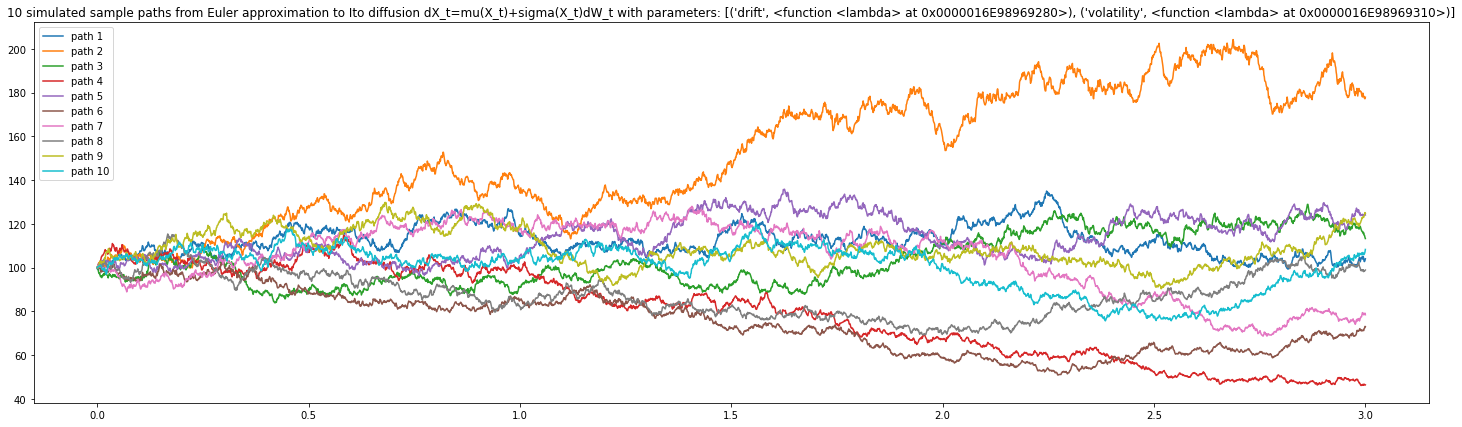

In [9]:
mu = 0.07
sigma = 0.2
drift_gbm = lambda t, x: mu * x
vol_gbm = lambda t, x: sigma * x

s = ItoDiffusionEuler(starting_value=100, drift_function=drift_gbm, volatility_function=vol_gbm, n=10, T=3, time_step=0.001, seed=None)
s.plot(10)

## 3.2 Cox-Ingersoll-Ross

$dX_t = \alpha(\beta-X_t) dt + \sigma \sqrt{ X_t^+} dW_t$, so $a(t,x)= \alpha(\beta-x)$ and $b(t,x)=\sigma \sqrt{\max\{0,x\}}$.

In [10]:
@interact(a=(-2.0, 2.0), b=(50, 120), sigma=(0.01, 0.5))
def aux_plot_cir(a, b, sigma):
    drift_cir = lambda t, x: a * (b - x)
    vol_cir = lambda t, x: sigma * np.sqrt(np.max(x, 0))
    s = ItoDiffusionEuler(
        starting_value=100,
        drift_function=drift_cir,
        volatility_function=vol_cir,
        n=10,
        T=25,
        time_step=0.001,
        seed=None,
    )
    s.plot(10)

interactive(children=(FloatSlider(value=0.0, description='a', max=2.0, min=-2.0), IntSlider(value=85, descript…

**Remarks**
- It can be proved, under parameter conditions $\alpha,\beta\geq 0$ and $2\alpha\beta >\sigma^2$, that the exact solution to the SDE is positive. So $X_t^+$ can be replaced by $X_t$. However, this does not mean that the Euler-method is guaranteed to yield nonnegative paths, so we use $x^+$ in our implementation.
- Although a closed-form solution of the form $X_t = f( W_s,\, s\leq t)$ is not available for the CIR-process,  the conditional distribution of $X_{t+h}$ given $\mathcal{F}_t$ is known (under the aforementioned parameter conditions). This can be used to obtain simulations from the exact solution to the SDE (on a (discrete) time-grid).